# <center>Case study - Mixup for times series</center>

In [2]:
# ALL IMPORT

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import shuffle
from scipy.io import arff

#pip install tslearn
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from sklearn.svm import SVC
from tslearn.metrics import cdist_gak

# PART 1

## I° What is Mixup ?

Mixup is a data augmentation technique introduced to improve the robustness and generalization of deep learning models, especially for neural networks. This method was proposed in 2018 in the paper "mixup: Beyond Empirical Risk Minimization" by Zhang et al. It is based on a simple idea: instead of using only the original data examples, synthetic examples are created by mixing pairs of inputs and their corresponding labels.

## II° Mixup Principle

The *mixup* technique consists in linearly combining two examples of a data set and their associated labels. Let $x_i$ and $x_j$ be two random examples of a data set with their respective labels $y_i$ and $y_j$. With a mixing parameter $\lambda$ drawn from a Beta distribution, we construct a new synthetic example $\tilde{x}$ and an associated label $\tilde{y}$ in the following way:

$$
\tilde{x} = \lambda x_i + (1 - \lambda) x_j
$$
$$
\tilde{y} = \lambda y_i + (1 - \lambda) y_j
$$

Where $\lambda$ is a hyperparameter controlling the proportion of each example in the mixture. Typically, $\lambda$ is drawn from a distribution $ \text{Beta}(\alpha, \alpha)$, with $\alpha > 0$, which allows controlling the intensity of the mixture.

## II° The 4 principals advantages of Mixup

1. **Better generalization**: *Mixup* allows the model to generalize better, because synthetic examples introduce variability into the training data, preventing the model from fitting only to the particularities of real examples.

2. **Reduced overfitting**: By introducing interpolated samples between different classes, the model becomes less likely to memorize specific examples and more likely to learn more general relationships.

3. **Robustness to adversarial perturbations**: Studies show that *Mixup* improves the resilience of models to adversarial attacks. By making decision boundaries smoother, *Mixup* reduces the vulnerabilities that attacks can exploit.

4. **Model stability**: By creating examples with fuzzy labels, *Mixup* introduces more stable learning, because it helps the model be less sensitive to extreme variations in the data.

## IV° Limitations of this concept

Mixup is widely used in classification tasks, especially for convolutional networks in computer vision. However, it is less effective in contexts where the input data cannot be linearly interpolated, such as texts or temporal sequences, although some adaptations exist.

## V° Simple illustrative example

Suppose we have two images representing a dog and a cat with their corresponding labels. By applying the *mixup*, we could create a new image visually mixing the dog and the cat, with an interpolated label that would indicate a probability of belonging to the class "dog" and "cat".

This method is very effective for tasks where the classes are visually distinct but share features, because it helps the model to build wider and more flexible decision boundaries between the classes.

# PART 2

## I° What data is used ?

In this study, **ECG200** dataset will be used to experiment with the mixup technique in time series classification. This dataset, composed of ECG (electrocardiogram) signal recordings, contains two classes indicating normal and abnormal heartbeats. By applying mixup, we will generate synthetic samples by combining signals from each class, which should help the model to generalize better and increase its robustness. This data is particularly suitable to evaluate how mixup can improve time series classification in a medical context where accuracy is essential.

In [3]:
def load_arff_files(train_file_path, test_file_path):
    """
    Charge les fichiers ARFF et les convertit en DataFrames pandas.

    Paramètres :
    - train_file_path (str) : Chemin du fichier d'entraînement.
    - test_file_path (str) : Chemin du fichier de test.

    Retourne :
    - df_train (pd.DataFrame) : Données d'apprentissage.
    - df_test (pd.DataFrame) : Données de test.
    """
    with open(train_file_path, 'r', encoding='utf-8') as train_file:
        data_train, _ = arff.loadarff(train_file)
    df_train = pd.DataFrame(data_train)

    with open(test_file_path, 'r', encoding='utf-8') as test_file:
        data_test, _ = arff.loadarff(test_file)
    df_test = pd.DataFrame(data_test)

    return df_train, df_test

In [4]:
train_path = 'ECG200_TRAIN.arff'
test_path = 'ECG200_TEST.arff'
df_train, df_test = load_arff_files(train_path, test_path)

# Afficher les 5 premières lignes des deux ensembles
print("Données d'entraînement (5 premières lignes) :")
print(df_train.head())
print("\nDonnées de test (5 premières lignes) :")
print(df_test.head())

Données d'entraînement (5 premières lignes) :
       att1      att2      att3      att4      att5      att6      att7  \
0  0.502055  0.542163  0.722383  1.428885  2.136516  2.281149  1.936274   
1  0.147647  0.804668  0.367771  0.243894  0.026614 -0.274402  0.096731   
2  0.316646  0.243199  0.370471  1.063738  1.678187  1.759558  1.697717   
3  1.168874  2.075901  1.760141  1.606446  1.949046  1.302842  0.459332   
4  0.648658  0.752026  2.636231  3.455716  2.118157  0.520620 -0.188627   

       att8      att9     att10  ...     att88     att89     att90     att91  \
0  1.468890  1.008845  0.380282  ...  0.610298  0.638894  0.684679  0.583238   
1 -0.747731 -1.609777 -1.179593  ... -0.400228  0.176084  1.111768  2.438428   
2  1.612159  1.168188  0.499957  ...  0.610621  0.552900  0.566786  0.604002   
3  0.516412  0.852180  0.989227  ...  0.723888  1.323947  2.136488  1.746597   
4  0.780818  0.933775  0.701402  ... -0.136787 -0.340237 -0.089441 -0.080297   

      att92     att93 

**Interpretation :** 

The data provided are ECG signal recordings, structured for heartbeat classification. Each row represents a single recording, composed of 96 attributes (att1 to att96), which capture the signal amplitude at different points in time, forming a sequence of values ​​representing the complete shape of the ECG signal. The target column indicates the class of each recording, with b'1' for a normal heartbeat and b'-1' for an abnormal beat. This data is commonly used to train classification models, allowing to identify anomalies in cardiac signals from their temporal characteristics.

## II° Objectif

### Plan of our first part of analysis


**1. Basic step (without Mixup)**
- Use the KNN with \( k = 1 \) on the initial data (training and test set).
- Calculate the accuracy on the training and test sets.
- Calculate the errors on the training and test sets (accuracy error).
- Calculate the generalization error, which is the difference between the test error and the training error.
- Generate a classification report to evaluate the model performance.

**2. Step with Mixup**
- Apply the *mixup* technique to enrich the training set, by generating additional synthetic data.
- Reapply the KNN with \( k = 1 \) on this enriched dataset.
- Calculate again the accuracy, the training and test errors, and the generalization error.
- Generate a new classification report to analyze how the *mixup* affects the model performance.

**Objective**
The final objective is to compare the KNN performance before and after applying the *mixup* to understand the impact of this technique on the model generalization and accuracy.

**BASIC STEP**

In [5]:
def evaluate_knn(train_file_path, test_file_path, k=1):
    """
    Effectue une évaluation du modèle KNN sur des données d'apprentissage et de test.

    Paramètres :
    - train_file_path (str) : Chemin du fichier d'entraînement (ARFF).
    - test_file_path (str) : Chemin du fichier de test (ARFF).
    - k (int) : Valeur de k pour le KNN (défaut : 1).
    """
    # Chargement des fichiers ARFF
    df_train, df_test = load_arff_files(train_file_path, test_file_path)

    # Séparation des features et des cibles
    X_train = df_train.iloc[:, :-1].astype(float).values  # Caractéristiques d'entraînement
    y_train = pd.get_dummies(df_train.iloc[:, -1]).values  # Cibles d'entraînement (one-hot encoding)
    X_test = df_test.iloc[:, :-1].astype(float).values    # Caractéristiques de test
    y_test = pd.get_dummies(df_test.iloc[:, -1]).values   # Cibles de test (one-hot encoding)

    # Création et entraînement du modèle KNN
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    # Prédictions
    y_train_pred = knn.predict(X_train)
    y_test_pred = knn.predict(X_test)

    # Calcul des précisions
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Calcul des erreurs
    train_error = 1 - train_accuracy
    test_error = 1 - test_accuracy

    # Erreur de généralisation
    generalization_error = test_error - train_error

    # Rapport de classification
    classification_rep = classification_report(y_test, y_test_pred, output_dict=True)

    # Affichage des résultats
    print("Précision (Entraînement) :", train_accuracy)
    print("Précision (Test) :", test_accuracy)
    print("Erreur (Entraînement) :", train_error)
    print("Erreur (Test) :", test_error)
    print("Erreur de généralisation :", generalization_error)
    print("Rapport de classification :\n\n")
    for label, metrics in classification_rep.items():
        print(f"{label} : {metrics}")

# Exemple d'utilisation
train_path = 'ECG200_TRAIN.arff'
test_path = 'ECG200_TEST.arff'
evaluate_knn(train_path, test_path, k=1)

Précision (Entraînement) : 1.0
Précision (Test) : 0.88
Erreur (Entraînement) : 0.0
Erreur (Test) : 0.12
Erreur de généralisation : 0.12
Rapport de classification :


0 : {'precision': 0.8529411764705882, 'recall': 0.8055555555555556, 'f1-score': 0.8285714285714286, 'support': 36.0}
1 : {'precision': 0.8939393939393939, 'recall': 0.921875, 'f1-score': 0.9076923076923077, 'support': 64.0}
micro avg : {'precision': 0.88, 'recall': 0.88, 'f1-score': 0.88, 'support': 100.0}
macro avg : {'precision': 0.8734402852049911, 'recall': 0.8637152777777778, 'f1-score': 0.8681318681318682, 'support': 100.0}
weighted avg : {'precision': 0.8791800356506237, 'recall': 0.88, 'f1-score': 0.8792087912087913, 'support': 100.0}
samples avg : {'precision': 0.88, 'recall': 0.88, 'f1-score': 0.88, 'support': 100.0}


## One-Hot Encoding in Machine Learning

One-hot encoding is a widely used method in machine learning for representing categorical data as binary vectors. It is particularly useful when working with algorithms that require numerical input, as categorical values cannot be directly processed. In one-hot encoding, each category is transformed into a binary vector where one position is set to 1 (active) and all other positions are 0. For example, if you have three classes (0, 1, and 2), they will be represented as [1, 0, 0], [0, 1, 0], and [0, 0, 1], respectively. This technique ensures that there is no ordinal relationship assumed between the categories.

In the context of advanced techniques like Mixup, one-hot encoding plays a crucial role. Mixup generates synthetic samples by interpolating between two existing data points, including their features and labels. To achieve this, class labels must be represented as continuous vectors. One-hot encoding provides the foundation for this by converting discrete labels into a numerical format that supports mathematical operations. During Mixup, two one-hot encoded labels are combined using a weighted sum, producing a probabilistic representation of the synthetic label.

One of the main advantages of one-hot encoding is that it prevents algorithms from assuming any ordinal or hierarchical relationship between categories. Additionally, it provides compatibility with a wide range of machine learning models, making it an essential preprocessing step for categorical data. However, one-hot encoding can lead to high memory usage if the number of categories is large, a problem known as the "curse of dimensionality." Despite this, it remains a fundamental and effective approach for handling categorical data in machine learning workflows.

## MIXUP FUNCTION

In [6]:
# Appliquer la technique Mixup
def apply_mixup(X, y, alpha, p):
    """
    Génère des échantillons synthétiques en utilisant Mixup.

    Paramètres :
    - X (ndarray) : Données d'entrée (features), matrice de taille (n_samples, n_features).
    - y (ndarray) : Cibles associées aux données, vecteur ou matrice (pour les cas multi-classes).
    - alpha (float) : Paramètre alpha pour la distribution bêta, contrôle la force du mélange entre les exemples.
    - p (float) : Proportion de nouvelles données à générer par rapport à la taille de X.

    Retourne :
    - X_mixup (ndarray) : Caractéristiques générées après application de Mixup.
    - y_mixup (ndarray) : Cibles générées après application de Mixup.
    """
    # Fixer la graine pour reproduire les résultats
    np.random.seed(42)

    # Calculer le nombre total d'échantillons à générer
    num_samples = int(p * len(X))  # p détermine la proportion des données à augmenter

    # Sélectionner des indices aléatoires avec remplacement parmi les données existantes
    indices = np.random.choice(len(X), size=num_samples, replace=True)

    # Générer des valeurs lambda pour chaque paire d'échantillons en utilisant une distribution bêta
    lambda_val = np.random.beta(alpha, alpha, num_samples)
    #print(lambda_val)

    # Initialiser des listes pour stocker les nouvelles données et leurs cibles
    X_mixup = []
    y_mixup = []

    # Parcourir les indices et leurs valeurs lambda correspondantes
    for i, l in zip(indices, lambda_val):
        # Sélectionner un second index aléatoire pour créer une paire
        j = np.random.choice(len(X))

        # Générer une nouvelle donnée synthétique en combinant deux échantillons
        # l contrôle la contribution de X[i] et (1 - l) celle de X[j]
        X_synthetic = l * X[i] + (1 - l) * X[j]

        # Générer une cible synthétique correspondante
        # Même principe que pour les données, mais appliqué aux cibles y
        y_synthetic = l * y[i] + (1 - l) * y[j]

        # Ajouter les données et cibles générées aux listes
        X_mixup.append(X_synthetic)
        y_mixup.append(y_synthetic)

    # Convertir les listes en tableaux NumPy pour les retourner
    #print(X_mixup)
    #print(y_mixup)
    
    return np.vstack(X_mixup), np.array(y_mixup)

In [7]:
def evaluate_knn_with_mixup(train_file_path, test_file_path, k, alpha, p):
    """
    Évalue les performances du KNN sur des données d'entraînement et de test,
    avant et après l'application de la technique Mixup.

    Paramètres :
    - train_file_path (str) : Chemin du fichier d'entraînement (ARFF).
    - test_file_path (str) : Chemin du fichier de test (ARFF).
    - k (int) : Valeur de k pour le KNN.
    - alpha (float) : Paramètre alpha de la distribution bêta pour le Mixup.
    - p (float) : Proportion de nouvelles données à générer (par rapport à la taille de l'ensemble d'entraînement).

    Retourne :
    - Tuple contenant la précision avant et après Mixup.
    """
    # Charger les fichiers d'entraînement et de test
    df_train, df_test = load_arff_files(train_file_path, test_file_path)

    # Préparer les données : 
    # - X contient les caractéristiques (features), 
    # - y contient les cibles (target).
    X_train = df_train.iloc[:, :-1].astype(float).values  # Caractéristiques d'entraînement
    y_train = pd.get_dummies(df_train.iloc[:, -1]).values  # Cibles d'entraînement (one-hot encoding)
    X_test = df_test.iloc[:, :-1].astype(float).values    # Caractéristiques de test
    y_test = pd.get_dummies(df_test.iloc[:, -1]).values   # Cibles de test (one-hot encoding)

    #print(y_train)

    # Évaluation initiale du KNN (avant Mixup)
    knn = KNeighborsClassifier(n_neighbors=k)  # Initialiser le modèle KNN avec k voisins
    knn.fit(X_train, np.argmax(y_train, axis=1))  # Entraîner le modèle sur les données d'entraînement

    # Générer des prédictions pour les données de test
    y_test_pred = knn.predict(X_test)
    original_test_accuracy = accuracy_score(np.argmax(y_test, axis=1), y_test_pred)

    if p > 0:
        # Appliquer la technique Mixup pour générer des données synthétiques
        X_mixup, y_mixup = apply_mixup(X_train, y_train, alpha=alpha, p=p)

        # Fusionner les données d'entraînement originales avec les données générées
        X_train_enriched = np.vstack([X_train, X_mixup])  # Nouvelles caractéristiques
        y_train_enriched = np.vstack([y_train, y_mixup])  # Nouvelles cibles

        #print(len(X_train_enriched))
        #print(len(y_train_enriched))

        # Réentraîner le modèle KNN sur les données enrichies
        knn.fit(X_train_enriched, np.argmax(y_train_enriched, axis=1))

        # Générer des prédictions pour les données de test après Mixup
        y_test_pred_enriched = knn.predict(X_test)
        enriched_test_accuracy = accuracy_score(np.argmax(y_test, axis=1), y_test_pred_enriched)
    else:
        enriched_test_accuracy = original_test_accuracy  # Pas de Mixup, utiliser la précision originale

    return original_test_accuracy, enriched_test_accuracy


# Exemple d'utilisation avec les chemins des fichiers ARFF
train_file_path = 'ECG200_TRAIN.arff' # Cas avec 3 classes diffèrentes
test_file_path = 'ECG200_TEST.arff'
evaluate_knn_with_mixup(train_file_path, test_file_path, 1, 3, 0.1)


(0.88, 0.89)

## Test sur de nombreuses banque de données : 

In [8]:
# Générer un tableau de précisions pour les variations de alpha
def generate_alpha_table(directory_path, k, p, alpha_values):
    """
    Génère un tableau où chaque ligne correspond à un jeu de données et chaque colonne contient
    la précision du modèle pour différentes valeurs de alpha.

    Paramètres :
    - directory_path (str) : Chemin du dossier contenant les fichiers ARFF.
    - k (int) : Valeur de k pour le KNN.
    - p (float) : Proportion de nouvelles données à générer (par rapport à la taille de X).
    - alpha_values (list) : Liste des valeurs de alpha à tester.

    Retourne :
    - Un tableau pandas contenant les précisions.
    """
    files = sorted(os.listdir(directory_path))
    train_files = [f for f in files if '_TRAIN.arff' in f]
    test_files = [f for f in files if '_TEST.arff' in f]

    results = []

    for train_file in train_files:
        base_name = train_file.replace('_TRAIN.arff', '')
        test_file = base_name + '_TEST.arff'

        if test_file in test_files:
            print(f"Traitement de : {base_name}")
            train_path = os.path.join(directory_path, train_file)
            test_path = os.path.join(directory_path, test_file)

            row = {"Dataset": base_name}

            # Précision sans Mixup
            original_acc, _ = evaluate_knn_with_mixup(train_path, test_path, k, alpha=0.0, p=0)
            row["No Mixup"] = original_acc

            # Précisions pour chaque valeur de alpha
            for alpha in alpha_values:
                _, enriched_acc = evaluate_knn_with_mixup(train_path, test_path, k, alpha, p)
                row[f"Mixup (alpha={alpha})"] = enriched_acc

            results.append(row)
        else:
            print(f"Fichier TEST manquant pour : {base_name}")

    # Créer un tableau pandas pour les résultats
    results_df = pd.DataFrame(results)

    # Afficher les résultats sous forme de tableau
    print("\nTableau des précisions :")
    print(results_df.to_string(index=False))

    return results_df

# Exemple d'utilisation
directory_path = 'Data'
alpha_values = [0.25, 0.5, 0.75, 1.5, 2, 5]
p = 0.5
results_table_alpha = generate_alpha_table(directory_path, k=1, p=p, alpha_values=alpha_values)


Traitement de : BME
Traitement de : Coffee
Traitement de : DodgerLoopGame_nmv
Traitement de : ECG200
Traitement de : GunPoint
Traitement de : ItalyPowerDemand
Traitement de : PowerCons
Traitement de : ScreenType
Traitement de : Strawberry
Traitement de : Wine
Traitement de : WormsTwoClass
Traitement de : Yoga

Tableau des précisions :
           Dataset  No Mixup  Mixup (alpha=0.25)  Mixup (alpha=0.5)  Mixup (alpha=0.75)  Mixup (alpha=1.5)  Mixup (alpha=2)  Mixup (alpha=5)
               BME  0.826667            0.826667           0.800000            0.793333           0.793333         0.793333         0.846667
            Coffee  1.000000            1.000000           1.000000            1.000000           1.000000         1.000000         1.000000
DodgerLoopGame_nmv  0.881890            0.881890           0.826772            0.881890           0.740157         0.732283         0.724409
            ECG200  0.880000            0.880000           0.870000            0.870000           0

In [9]:
# Générer un tableau de précisions pour les variations de p_values
def generate_precision_table(directory_path, k, alpha, p_values):
    """
    Génère un tableau où chaque ligne correspond à un jeu de données et chaque colonne contient
    la précision du modèle pour différentes valeurs de p.

    Paramètres :
    - directory_path (str) : Chemin du dossier contenant les fichiers ARFF.
    - k (int) : Valeur de k pour le KNN.
    - alpha (float) : Valeur de alpha pour Mixup.
    - p_values (list) : Liste des proportions p à tester.

    Retourne :
    - Un tableau pandas contenant les précisions.
    """
    files = sorted(os.listdir(directory_path))
    train_files = [f for f in files if '_TRAIN.arff' in f]
    test_files = [f for f in files if '_TEST.arff' in f]

    results = []

    for train_file in train_files:
        base_name = train_file.replace('_TRAIN.arff', '')
        test_file = base_name + '_TEST.arff'

        if test_file in test_files:
            print(f"Traitement de : {base_name}")
            train_path = os.path.join(directory_path, train_file)
            test_path = os.path.join(directory_path, test_file)

            row = {"Dataset": base_name}

            # Précision sans Mixup
            original_acc, _ = evaluate_knn_with_mixup(train_path, test_path, k, alpha, p=0)
            row["No Mixup"] = original_acc

            # Précisions pour chaque valeur de p
            for p in p_values:
                _, enriched_acc = evaluate_knn_with_mixup(train_path, test_path, k, alpha, p)
                row[f"Mixup (p={p})"] = enriched_acc

            results.append(row)
        else:
            print(f"Fichier TEST manquant pour : {base_name}")

    # Créer un tableau pandas pour les résultats
    results_df = pd.DataFrame(results)

    # Afficher les résultats sous forme de tableau
    print("\nTableau des précisions :")
    print(results_df.to_string(index=False))

    return results_df

# Exemple d'utilisation
directory_path = 'Data'
p_values = [0.25, 0.5, 0.75, 1.5, 2, 5]
alpha = 0.5
results_table = generate_precision_table(directory_path, k=1, alpha=alpha, p_values=p_values)

Traitement de : BME
Traitement de : Coffee
Traitement de : DodgerLoopGame_nmv
Traitement de : ECG200
Traitement de : GunPoint
Traitement de : ItalyPowerDemand
Traitement de : PowerCons
Traitement de : ScreenType
Traitement de : Strawberry
Traitement de : Wine
Traitement de : WormsTwoClass
Traitement de : Yoga

Tableau des précisions :
           Dataset  No Mixup  Mixup (p=0.25)  Mixup (p=0.5)  Mixup (p=0.75)  Mixup (p=1.5)  Mixup (p=2)  Mixup (p=5)
               BME  0.826667        0.786667       0.800000        0.813333       0.820000     0.813333     0.780000
            Coffee  1.000000        1.000000       1.000000        1.000000       1.000000     1.000000     1.000000
DodgerLoopGame_nmv  0.881890        0.834646       0.826772        0.858268       0.803150     0.692913     0.818898
            ECG200  0.880000        0.870000       0.870000        0.870000       0.910000     0.890000     0.910000
          GunPoint  0.913333        0.900000       0.913333        0.906667   

In [9]:
def plot_precision_graphs(results_df, p_values):
    """
    Génère des graphiques pour chaque valeur de p, répartis sur deux lignes.

    Paramètres :
    - results_df (pd.DataFrame) : Tableau des précisions généré par generate_precision_table.
    - p_values (list) : Liste des valeurs de p utilisées dans Mixup.
    """
    num_graphs = len(p_values)
    rows = 2
    cols = (num_graphs + 1) // 2  # Calcul du nombre de colonnes sur deux lignes

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows), sharey=True)
    axes = axes.flatten()  # Aplatir pour un accès uniforme aux axes

    for i, p in enumerate(p_values):
        ax = axes[i]
        x = results_df["No Mixup"]
        y = results_df[f"Mixup (p={p})"]

        # Scatter plot avec labels des points
        ax.scatter(x, y, label=f"p={p}")
        for j, txt in enumerate(results_df["Dataset"]):
            ax.annotate(txt, (x.iloc[j], y.iloc[j]), fontsize=8)

        # Ligne de référence
        ax.plot([0, 1], [0, 1], 'r--', label="y=x")
        ax.set_xlabel("Précision sans Mixup")
        ax.set_ylabel("Précision avec Mixup")
        ax.set_title(f"Précision : No Mixup vs Mixup (p={p})")
        ax.legend()
        ax.grid()

    # Supprimer les axes inutilisés si p_values ne remplit pas toutes les cases
    for i in range(len(p_values), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

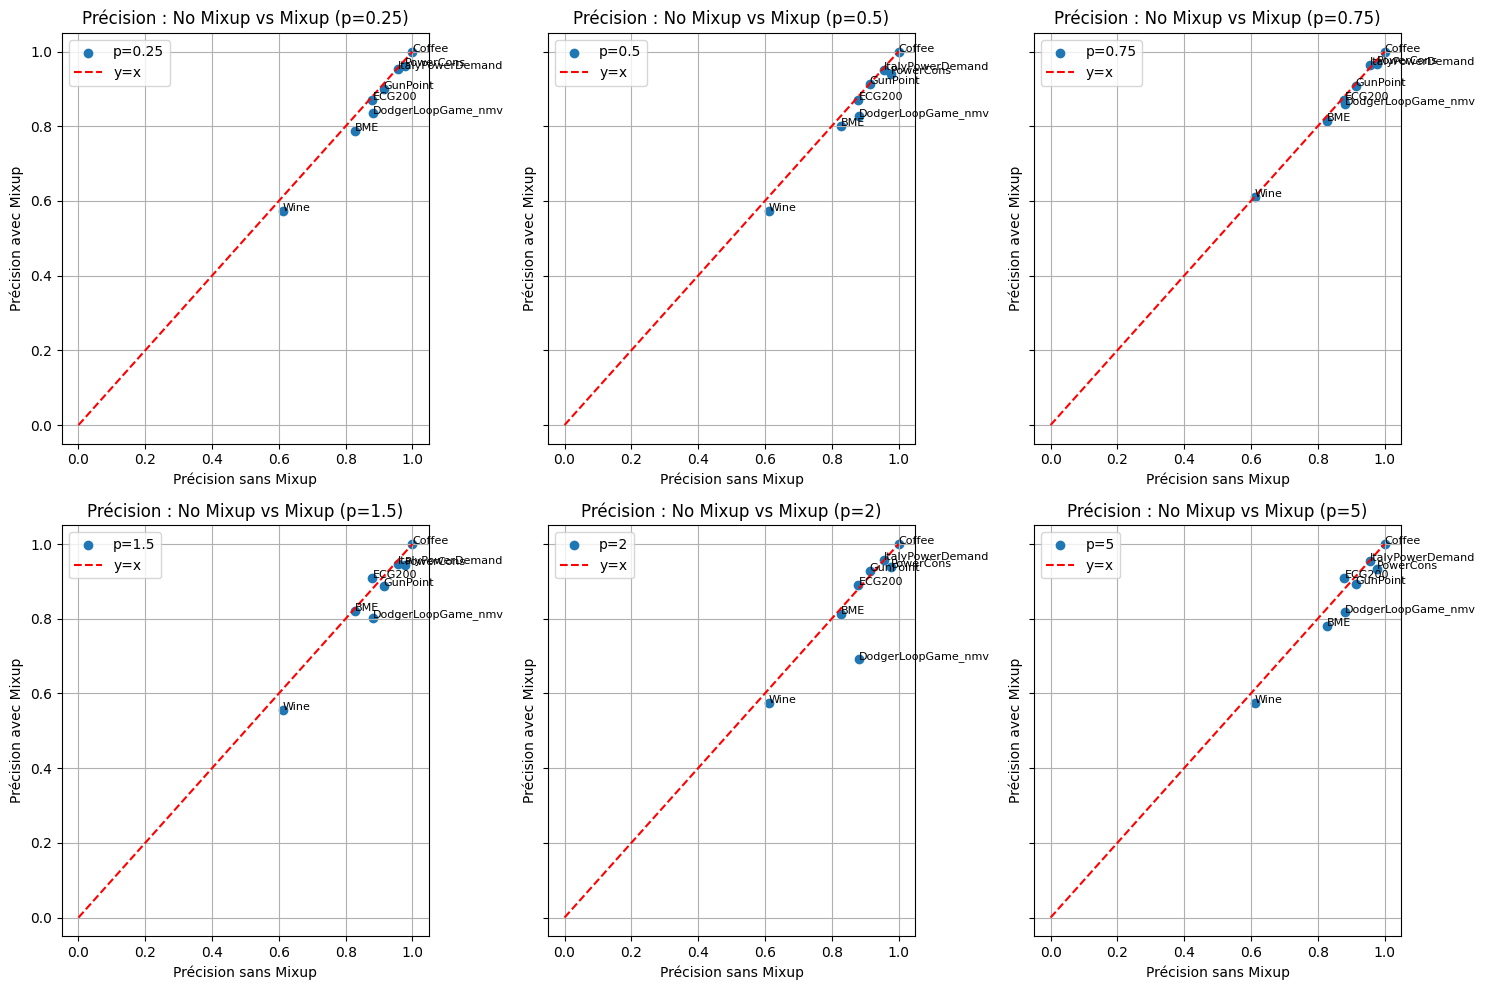

In [10]:
plot_precision_graphs(results_table, p_values)

# 1NN-DTW

1NN-DTW (1-Nearest Neighbor with Dynamic Time Warping) is a classifier used for time series. Unlike classical KNN, which relies on standard distances like Euclidean, 1NN-DTW uses the Dynamic Time Warping algorithm to measure the similarity between two time series, even if they have time lags or local variations. DTW is particularly useful in domains such as ECG analysis, human motion or speech recognition, where data are not always perfectly aligned.

In this classifier, for each example to be predicted, the DTW distance is calculated between this example and all series in the training set. The closest example (with the smallest DTW distance) determines the predicted class. This allows to better capture complex temporal variations, making 1NN-DTW very efficient for time series where strict alignments fail.

However, this method has high complexity due to the intensive computation of DTW for each pair of series.

In [10]:
def evaluate_1nn_dtw_with_mixup(train_file_path, test_file_path, alpha, p):
    """
    Évalue les performances de 1NN-DTW sur des données d'entraînement et de test,
    avant et après l'application de la technique Mixup.

    Paramètres :
    - train_file_path (str) : Chemin du fichier d'entraînement (ARFF).
    - test_file_path (str) : Chemin du fichier de test (ARFF).
    - alpha (float) : Paramètre alpha de la distribution bêta pour le Mixup.
    - p (float) : Proportion de nouvelles données à générer (par rapport à la taille de l'ensemble d'entraînement).

    Retourne :
    - Tuple contenant la précision avant et après Mixup.
    """
    # Charger les fichiers d'entraînement et de test
    df_train, df_test = load_arff_files(train_file_path, test_file_path)

    # Préparer les données
    X_train = df_train.iloc[:, :-1].astype(float).values  # Caractéristiques d'entraînement
    y_train = pd.get_dummies(df_train.iloc[:, -1]).values  # Cibles d'entraînement (one-hot encoding)
    X_test = df_test.iloc[:, :-1].astype(float).values    # Caractéristiques de test
    y_test = pd.get_dummies(df_test.iloc[:, -1]).values   # Cibles de test (one-hot encoding)

    # Reshape pour tslearn
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Évaluation initiale de 1NN-DTW (avant Mixup)
    knn_dtw = KNeighborsTimeSeriesClassifier(n_neighbors=1, metric="dtw")
    knn_dtw.fit(X_train, np.argmax(y_train, axis=1))  # Conversion one-hot en index

    # Prédictions pour les données de test
    y_test_pred = knn_dtw.predict(X_test)
    original_test_accuracy = accuracy_score(np.argmax(y_test, axis=1), y_test_pred)

    if p > 0:
        # Appliquer Mixup pour générer des données synthétiques
        X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Mise à plat pour Mixup
        X_mixup, y_mixup = apply_mixup(X_train_flat, y_train, alpha=alpha, p=p)

        # Reshape des données générées pour tslearn
        X_mixup = X_mixup.reshape(X_mixup.shape[0], X_train.shape[1], 1)
        y_mixup = np.argmax(y_mixup, axis=1)  # Décodage one-hot en index

        # Fusionner les données
        X_train_enriched = np.vstack([X_train, X_mixup])
        y_train_enriched = np.hstack([np.argmax(y_train, axis=1), y_mixup])

        # Réentraîner le modèle sur les données enrichies
        knn_dtw.fit(X_train_enriched, y_train_enriched)

        # Prédictions après Mixup
        y_test_pred_enriched = knn_dtw.predict(X_test)
        enriched_test_accuracy = accuracy_score(np.argmax(y_test, axis=1), y_test_pred_enriched)
    else:
        enriched_test_accuracy = original_test_accuracy

    return original_test_accuracy, enriched_test_accuracy


In [11]:
train_file_path = "ECG200_TRAIN.arff"  
test_file_path = "ECG200_TEST.arff"    

alpha = 1
p = 1.0      

# Appel de la fonction
original_acc, enriched_acc = evaluate_1nn_dtw_with_mixup(train_file_path, test_file_path, alpha, p)
# Affichage des résultats
print(f"Précision avant Mixup (1NN-DTW) : {original_acc:.4f}")
print(f"Précision après Mixup (1NN-DTW)  : {enriched_acc:.4f}")


Précision avant Mixup (1NN-DTW) : 0.7700
Précision après Mixup (1NN-DTW)  : 0.8000


# SVM+GAK Classifier

SVM+GAK is a classifier combining the power of the Support Vector Machine (SVM) and the Global Alignment Kernel (GAK). The SVM is a supervised algorithm that separates data into classes by finding an optimal hyperplane. The GAK, used as a kernel, measures the similarity between two time series inspired by the Dynamic Time Warping (DTW) algorithm, but with a formulation that ensures that the kernel is positive definite. This allows to handle time series with time lags and local variations. The SVM then uses this similarity measure to classify the time series. This classifier is particularly suitable for complex data such as motion, biomedical signals (ECG) or speech recognition, where strict alignments fail. However, its use can be computationally expensive, especially for large datasets.

In [12]:
from tslearn.svm import TimeSeriesSVC

def evaluate_svm_gak_with_mixup(train_file_path, test_file_path, alpha, p, gamma):
    """
    Évalue les performances de SVM+GAK sur des données d'entraînement et de test,
    avant et après l'application de la technique Mixup.

    Paramètres :
    - train_file_path (str) : Chemin du fichier d'entraînement (ARFF).
    - test_file_path (str) : Chemin du fichier de test (ARFF).
    - alpha (float) : Paramètre alpha pour la distribution bêta (Mixup).
    - p (float) : Proportion des données synthétiques générées (Mixup).
    - gamma (float) : Paramètre gamma pour le noyau GAK.

    Retourne :
    - Tuple (float, float) : Précisions avant et après Mixup.
    """
    # Charger les fichiers ARFF en DataFrames
    df_train, df_test = load_arff_files(train_file_path, test_file_path)

    # Extraire les caractéristiques (X) et les cibles (y) des données d'entraînement et de test
    X_train = df_train.iloc[:, :-1].astype(float).values  # Caractéristiques d'entraînement
    y_train = pd.get_dummies(df_train.iloc[:, -1]).values  # Cibles (one-hot encoding)
    X_test = df_test.iloc[:, :-1].astype(float).values    # Caractéristiques de test
    y_test = pd.get_dummies(df_test.iloc[:, -1]).values   # Cibles de test (one-hot encoding)

    # Initialiser le SVM avec le noyau GAK
    clf = TimeSeriesSVC(kernel="gak", gamma=gamma)

    # Entraîner le SVM sur les données d'entraînement originales
    clf.fit(X_train, np.argmax(y_train, axis=1))  # np.argmax décode les cibles one-hot en indices
    # Précision initiale sur les données de test
    original_test_accuracy = clf.score(X_test, np.argmax(y_test, axis=1))

    # Appliquer Mixup si p > 0
    if p > 0:
        # Générer des données synthétiques avec Mixup
        X_mixup, y_mixup = apply_mixup(X_train, y_train, alpha=alpha, p=p)

        # Fusionner les données d'entraînement originales et synthétiques
        X_train_enriched = np.vstack([X_train, X_mixup])
        y_train_enriched = np.vstack([y_train, y_mixup])

        # Réentraîner le SVM sur les données enrichies
        clf.fit(X_train_enriched, np.argmax(y_train_enriched, axis=1))

        # Précision sur les données de test après Mixup
        enriched_test_accuracy = clf.score(X_test, np.argmax(y_test, axis=1))
    else:
        # Si p == 0, la précision après Mixup est identique à la précision originale
        enriched_test_accuracy = original_test_accuracy

    # Retourner les précisions avant et après Mixup
    return original_test_accuracy, enriched_test_accuracy


In [13]:
train_file_path = "ECG200_TRAIN.arff"
test_file_path = "ECG200_TEST.arff"
alpha = 0.5
p = 1.0
gamma = 0.1

original_acc, enriched_acc = evaluate_svm_gak_with_mixup(train_file_path, test_file_path, alpha, p, gamma)

print(f"Précision avant Mixup (SVM+GAK) : {original_acc:.4f}")
print(f"Précision après Mixup (SVM+GAK)  : {enriched_acc:.4f}")

Précision avant Mixup (SVM+GAK) : 0.6400
Précision après Mixup (SVM+GAK)  : 0.6400


# Generate precision table with all models

In [ ]:
def generate_precision_table_with_models(directory_path, k, alpha, p_values, gamma, n_shapelets_per_class, max_iter):
    """
    Génère un tableau où chaque ligne correspond à un jeu de données et chaque colonne contient
    la précision du modèle pour différentes valeurs de p, avec les résultats pour plusieurs classifieurs.

    Paramètres :
    - directory_path (str) : Chemin du dossier contenant les fichiers ARFF.
    - k (int) : Valeur de k pour le KNN.
    - alpha (float) : Valeur de alpha pour Mixup.
    - p_values (list) : Liste des proportions p à tester.
    - gamma (float) : Paramètre gamma pour le noyau GAK dans SVM+GAK.
    - n_shapelets_per_class (int) : Nombre de shapelets à apprendre par classe pour le Shapelet Model.
    - max_iter (int) : Nombre maximal d'itérations pour le Shapelet Model.

    Retourne :
    - Un tableau pandas contenant les précisions pour chaque modèle.
    """
    files = sorted(os.listdir(directory_path))
    train_files = [f for f in files if '_TRAIN.arff' in f]
    test_files = [f for f in files if '_TEST.arff' in f]

    results = []

    for train_file in train_files:
        base_name = train_file.replace('_TRAIN.arff', '')
        test_file = base_name + '_TEST.arff'

        if test_file in test_files:
            print(f"Traitement de : {base_name}")
            train_path = os.path.join(directory_path, train_file)
            test_path = os.path.join(directory_path, test_file)

            # Classifieurs à évaluer
            classifiers = [
                ("1NN-KNN", lambda t, e, a, p: evaluate_knn_with_mixup(t, e, k, a, p)),
                ("1NN-DTW", lambda t, e, a, p: evaluate_1nn_dtw_with_mixup(t, e, a, p)),
                ("SVM+GAK", lambda t, e, a, p: evaluate_svm_gak_with_mixup(t, e, a, p, gamma))            ]

            for classifier_name, classifier_func in classifiers:
                row = {"Dataset": base_name, "Classifier": classifier_name}

                # Précision sans Mixup
                original_acc, _ = classifier_func(train_path, test_path, alpha, p=0)
                row["No Mixup"] = original_acc

                # Précisions pour chaque valeur de p
                for p in p_values:
                    _, enriched_acc = classifier_func(train_path, test_path, alpha, p)
                    row[f"Mixup (p={p})"] = enriched_acc

                results.append(row)
        else:
            print(f"Fichier TEST manquant pour : {base_name}")

    # Créer un tableau pandas pour les résultats
    results_df = pd.DataFrame(results)

    # Afficher les résultats sous forme de tableau
    print("\nTableau des précisions :")
    print(results_df.to_string(index=False))

    return results_df

directory_path = 'Data'
p_values = [0.25, 0.5, 0.75, 1.5, 2, 3]
alpha = 0.5
k = 1
gamma = 0.1
n_shapelets_per_class = 2
max_iter = 2
results_table = generate_precision_table_with_models(directory_path, k, alpha, p_values, gamma, n_shapelets_per_class, max_iter)

In [20]:
def load_results_from_csv(filename):
    """
    Charge les résultats depuis un fichier CSV.

    Paramètres :
    - filename (str) : Nom du fichier CSV à charger.

    Retourne :
    - pd.DataFrame : Tableau des précisions chargé depuis le fichier.
    """
    results_df = pd.read_csv(filename)
    print(f"Les résultats ont été chargés depuis le fichier : {filename}")
    return results_df

loaded_results_p = load_results_from_csv("datap.csv")
print(loaded_results_p)

Les résultats ont été chargés depuis le fichier : datap.csv
                     Dataset                        NoMixup Mixup(p=0.25)  \
0                      ACSF1                       0.540000      0.530000   
1              MedicalImages                       0.684211      0.684211   
2    MelbournePedestrian_nmv                       0.944373      0.932298   
3        PenDigitsDimension1                       0.854774      0.853917   
4        PenDigitsDimension2                       0.848199      0.847627   
..                       ...                            ...           ...   
213               DataClass8  UWaveGestureLibraryDimension2      0.590625   
214               DataClass8  UWaveGestureLibraryDimension3      0.571875   
215               DataClass8           UWaveGestureLibraryX      0.739252   
216               DataClass8           UWaveGestureLibraryY      0.661642   
217               DataClass8           UWaveGestureLibraryZ      0.649637   

    Mixup(p=0.5

In [ ]:
# Générer un tableau de précisions pour les variations de p_values
def generate_precision_table_for_all_classes(base_directory, k, alpha, p_values):
    """
    Génère un tableau de précisions pour chaque classe spécifiée dans les dossiers.

    Paramètres :
    - base_directory (str) : Chemin du répertoire de base contenant les dossiers de classes.
    - k (int) : Valeur de k pour le KNN.
    - alpha (float) : Valeur de alpha pour Mixup.
    - p_values (list) : Liste des proportions p à tester.

    Retourne :
    - Un tableau pandas combiné contenant les précisions pour toutes les classes.
    """
    all_results = []

    # Parcourir les dossiers de classes
    for class_folder in sorted(os.listdir(base_directory)):
        class_path = os.path.join(base_directory, class_folder)
        if not os.path.isdir(class_path):
            continue

        print(f"\nTraitement des données pour la classe : {class_folder}")

        # Générer le tableau pour ce dossier spécifique
        results_df = generate_precision_table(class_path, k, alpha, p_values)

        # Ajouter une colonne pour identifier la classe
        results_df.insert(0, "Class", class_folder)
        all_results.append(results_df)

    # Combiner tous les tableaux
    combined_results = pd.concat(all_results, ignore_index=True)

    # Afficher les résultats combinés
    print("\nTableau combiné des précisions :")
    print(combined_results.to_string(index=False))

    return combined_results

# Exemple d'utilisation
base_directory = 'AllData'  # Remplacer par le chemin réel
p_values = [0.25, 0.5, 0.75, 1.5, 2, 5]
alpha = 0.5
k = 1
combined_results = generate_precision_table_for_all_classes(base_directory, k, alpha, p_values)


In [14]:
# Générer des graphiques sans labels pour chaque valeur de p
def plot_precision_graphs_without_label(results_df, p_values):
    """
    Génère des graphiques pour chaque valeur de p sans labels sur les points.

    Paramètres :
    - results_df (pd.DataFrame) : Tableau des précisions généré par generate_precision_table.
    - p_values (list) : Liste des valeurs de p utilisées dans Mixup.
    """
    num_graphs = len(p_values)
    rows = 2
    cols = (num_graphs + 1) // 2  # Calcul du nombre de colonnes sur deux lignes

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows), sharey=True)
    axes = axes.flatten()  # Aplatir pour un accès uniforme aux axes

    for i, p in enumerate(p_values):
        ax = axes[i]
        x = results_df["NoMixup"]
        y = results_df[f"Mixup(p={p})"]

        # Scatter plot sans labels des points
        ax.scatter(x, y, label=f"p={p}")

        # Ligne de référence
        ax.plot([0, 1], [0, 1], 'r--', label="y=x")
        ax.set_xlabel("Précision sans Mixup")
        ax.set_ylabel("Précision avec Mixup")
        ax.set_title(f"Précision : No Mixup vs Mixup (p={p})")
        ax.legend()
        ax.grid()

    # Supprimer les axes inutilisés si p_values ne remplit pas toutes les cases
    for i in range(len(p_values), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

plot_precision_graphs_without_label(loaded_results_p, p_values)

In [15]:
# Fonction pour générer des graphiques de précision

def plot_precision_graphs_without_label(results_df, p_values):
    """
    Génère des graphiques pour chaque valeur de p sans labels sur les points.

    Paramètres :
    - results_df (pd.DataFrame) : Tableau des précisions contenant les résultats des classifiers avec et sans Mixup.
    - p_values (list) : Liste des valeurs de p utilisées dans Mixup.
    """
    num_graphs = len(p_values)
    rows = 2  # Nombre de lignes fixes pour l'affichage
    cols = (num_graphs + 1) // 2  # Calcul du nombre de colonnes nécessaires

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows), sharey=True)
    axes = axes.flatten()  # Aplatir pour un accès uniforme aux axes

    for i, p in enumerate(p_values):
        ax = axes[i]
        # Précisions pour "No Mixup" et "Mixup (p={valeur})"
        x = results_df["NoMixup"]
        y = results_df[f"Mixup(p={p})"]

        # Scatter plot sans labels sur les points
        ax.scatter(x, y)

        # Ligne de référence pour y = x
        ax.plot([0, 1], [0, 1], 'r--', label="y=x")
        ax.set_xlabel("Précision sans Mixup")
        ax.set_ylabel(f"Précision avec Mixup (p={p})")
        ax.set_title(f"No Mixup vs Mixup (p={p})")
        ax.grid(True)

    # Supprimer les axes inutilisés si p_values ne remplit pas toutes les cases
    for i in range(len(p_values), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

# Liste des valeurs de p
p_values = [0.25, 0.5, 0.75, 1.5, 2, 5]

# Appel de la fonction
plot_precision_graphs_without_label(loaded_results_p, p_values)

NameError: name 'loaded_results_p' is not defined

In [16]:
# Fonction pour sauvegarder les résultats sous format CSV
def save_results_to_csv(results_table, filename):
    """
    Sauvegarde les résultats dans un fichier CSV.

    Paramètres :
    - results_df (pd.DataFrame) : Tableau des précisions contenant les résultats.
    - filename (str) : Nom du fichier CSV à créer.
    """
    results_table.to_csv(filename, index=False)
    print(f"Les résultats ont été sauvegardés dans le fichier : {filename}")

save_results_to_csv(results_table, "results_mixup.csv")

Les résultats ont été sauvegardés dans le fichier : results_mixup.csv


In [14]:
def load_results_from_csv(filename):
    """
    Charge les résultats depuis un fichier CSV.

    Paramètres :
    - filename (str) : Nom du fichier CSV à charger.

    Retourne :
    - pd.DataFrame : Tableau des précisions chargé depuis le fichier.
    """
    results_df = pd.read_csv(filename)
    print(f"Les résultats ont été chargés depuis le fichier : {filename}")
    return results_df

loaded_results = load_results_from_csv("results_mixup.csv")
print(loaded_results)

Les résultats ont été chargés depuis le fichier : results_mixup.csv
               Dataset Classifier  No Mixup  Mixup (p=0.25)  Mixup (p=0.5)  \
0                  BME    1NN-KNN  0.826667        0.786667       0.800000   
1                  BME    1NN-DTW  0.893333        0.886667       0.893333   
2                  BME    SVM+GAK  0.626667        0.653333       0.660000   
3               Coffee    1NN-KNN  1.000000        1.000000       1.000000   
4               Coffee    1NN-DTW  1.000000        1.000000       1.000000   
5               Coffee    SVM+GAK  0.821429        0.464286       0.464286   
6   DodgerLoopGame_nmv    1NN-KNN  0.881890        0.834646       0.826772   
7   DodgerLoopGame_nmv    1NN-DTW  0.897638        0.881890       0.905512   
8   DodgerLoopGame_nmv    SVM+GAK  0.511811        0.511811       0.511811   
9               ECG200    1NN-KNN  0.880000        0.870000       0.870000   
10              ECG200    1NN-DTW  0.770000        0.760000       0.770000

# Critical diagram

In [15]:
# Fonction pour transformer le fichier CSV au format désiré
def transform_results_to_custom_format(results_df):
    """
    Transforme le DataFrame des résultats en un nouveau format avec les colonnes :
    - classifier_name
    - dataset_name
    - accuracy

    Paramètres :
    - results_df (pd.DataFrame) : Tableau des résultats contenant les classifiers, datasets et précisions.

    Retourne :
    - pd.DataFrame : Tableau transformé au nouveau format.
    """
    transformed_data = []
    for index, row in results_df.iterrows():
        dataset_name = row["Dataset"]
        classifier_base = row["Classifier"]
        for col in results_df.columns[2:]:  # Ignorer Dataset et Classifier
            if col.startswith("Mixup"):
                p_value = col.split("=")[1][:-1]  # Extraire la valeur de p
                classifier_name = f"{classifier_base}_p={p_value}"
                accuracy = row[col]
                transformed_data.append({
                    "classifier_name": classifier_name,
                    "dataset_name": dataset_name,
                    "accuracy": accuracy
                })

    return pd.DataFrame(transformed_data)

transformed_results = transform_results_to_custom_format(loaded_results)
save_results_to_csv(transformed_results, "transformed_results.csv")

Les résultats ont été sauvegardés dans le fichier : transformed_results.csv


In [17]:
# Author: Hassan Ismail Fawaz <hassan.ismail-fawaz@uha.fr>
#         Germain Forestier <germain.forestier@uha.fr>
#         Jonathan Weber <jonathan.weber@uha.fr>
#         Lhassane Idoumghar <lhassane.idoumghar@uha.fr>
#         Pierre-Alain Muller <pierre-alain.muller@uha.fr>
# License: GPL3

import numpy as np
import pandas as pd
import matplotlib

matplotlib.use('agg')
import matplotlib.pyplot as plt

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Arial'

import operator
import math
from scipy.stats import wilcoxon
from scipy.stats import friedmanchisquare
import networkx

# inspired from orange3 https://docs.orange.biolab.si/3/data-mining-library/reference/evaluation.cd.html
def graph_ranks(avranks, names, p_values, cd=None, cdmethod=None, lowv=None, highv=None,
                width=6, textspace=1, reverse=False, filename=None, labels=False, **kwargs):
    """
    Draws a CD graph, which is used to display  the differences in methods'
    performance. See Janez Demsar, Statistical Comparisons of Classifiers over
    Multiple Data Sets, 7(Jan):1--30, 2006.

    Needs matplotlib to work.

    The image is ploted on `plt` imported using
    `import matplotlib.pyplot as plt`.

    Args:
        avranks (list of float): average ranks of methods.
        names (list of str): names of methods.
        cd (float): Critical difference used for statistically significance of
            difference between methods.
        cdmethod (int, optional): the method that is compared with other methods
            If omitted, show pairwise comparison of methods
        lowv (int, optional): the lowest shown rank
        highv (int, optional): the highest shown rank
        width (int, optional): default width in inches (default: 6)
        textspace (int, optional): space on figure sides (in inches) for the
            method names (default: 1)
        reverse (bool, optional):  if set to `True`, the lowest rank is on the
            right (default: `False`)
        filename (str, optional): output file name (with extension). If not
            given, the function does not write a file.
        labels (bool, optional): if set to `True`, the calculated avg rank
        values will be displayed
    """
    try:
        import matplotlib
        import matplotlib.pyplot as plt
        from matplotlib.backends.backend_agg import FigureCanvasAgg
    except ImportError:
        raise ImportError("Function graph_ranks requires matplotlib.")

    width = float(width)
    textspace = float(textspace)

    def nth(l, n):
        """
        Returns only nth elemnt in a list.
        """
        n = lloc(l, n)
        return [a[n] for a in l]

    def lloc(l, n):
        """
        List location in list of list structure.
        Enable the use of negative locations:
        -1 is the last element, -2 second last...
        """
        if n < 0:
            return len(l[0]) + n
        else:
            return n

    def mxrange(lr):
        """
        Multiple xranges. Can be used to traverse matrices.
        This function is very slow due to unknown number of
        parameters.

        >>> mxrange([3,5])
        [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]

        >>> mxrange([[3,5,1],[9,0,-3]])
        [(3, 9), (3, 6), (3, 3), (4, 9), (4, 6), (4, 3)]

        """
        if not len(lr):
            yield ()
        else:
            # it can work with single numbers
            index = lr[0]
            if isinstance(index, int):
                index = [index]
            for a in range(*index):
                for b in mxrange(lr[1:]):
                    yield tuple([a] + list(b))

    def print_figure(fig, *args, **kwargs):
        canvas = FigureCanvasAgg(fig)
        canvas.print_figure(*args, **kwargs)

    sums = avranks

    nnames = names
    ssums = sums

    if lowv is None:
        lowv = min(1, int(math.floor(min(ssums))))
    if highv is None:
        highv = max(len(avranks), int(math.ceil(max(ssums))))

    cline = 0.4

    k = len(sums)

    lines = None

    linesblank = 0
    scalewidth = width - 2 * textspace

    def rankpos(rank):
        if not reverse:
            a = rank - lowv
        else:
            a = highv - rank
        return textspace + scalewidth / (highv - lowv) * a

    distanceh = 0.25

    cline += distanceh

    # calculate height needed height of an image
    minnotsignificant = max(2 * 0.2, linesblank)
    height = cline + ((k + 1) / 2) * 0.2 + minnotsignificant

    fig = plt.figure(figsize=(width, height))
    fig.set_facecolor('white')
    ax = fig.add_axes([0, 0, 1, 1])  # reverse y axis
    ax.set_axis_off()

    hf = 1. / height  # height factor
    wf = 1. / width

    def hfl(l):
        return [a * hf for a in l]

    def wfl(l):
        return [a * wf for a in l]

    # Upper left corner is (0,0).
    ax.plot([0, 1], [0, 1], c="w")
    ax.set_xlim(0, 1)
    ax.set_ylim(1, 0)

    def line(l, color='k', **kwargs):
        """
        Input is a list of pairs of points.
        """
        ax.plot(wfl(nth(l, 0)), hfl(nth(l, 1)), color=color, **kwargs)

    def text(x, y, s, *args, **kwargs):
        ax.text(wf * x, hf * y, s, *args, **kwargs)

    line([(textspace, cline), (width - textspace, cline)], linewidth=2)

    bigtick = 0.3
    smalltick = 0.15
    linewidth = 2.0
    linewidth_sign = 4.0

    tick = None
    for a in list(np.arange(lowv, highv, 0.5)) + [highv]:
        tick = smalltick
        if a == int(a):
            tick = bigtick
        line([(rankpos(a), cline - tick / 2),
              (rankpos(a), cline)],
             linewidth=2)

    for a in range(lowv, highv + 1):
        text(rankpos(a), cline - tick / 2 - 0.05, str(a),
             ha="center", va="bottom", size=16)

    k = len(ssums)

    def filter_names(name):
        return name

    space_between_names = 0.24

    for i in range(math.ceil(k / 2)):
        chei = cline + minnotsignificant + i * space_between_names
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace - 0.1, chei)],
             linewidth=linewidth)
        if labels:
            text(textspace + 0.3, chei - 0.075, format(ssums[i], '.4f'), ha="right", va="center", size=10)
        text(textspace - 0.2, chei, filter_names(nnames[i]), ha="right", va="center", size=16)

    for i in range(math.ceil(k / 2), k):
        chei = cline + minnotsignificant + (k - i - 1) * space_between_names
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace + scalewidth + 0.1, chei)],
             linewidth=linewidth)
        if labels:
            text(textspace + scalewidth - 0.3, chei - 0.075, format(ssums[i], '.4f'), ha="left", va="center", size=10)
        text(textspace + scalewidth + 0.2, chei, filter_names(nnames[i]),
             ha="left", va="center", size=16)

    # no-significance lines
    def draw_lines(lines, side=0.05, height=0.1):
        start = cline + 0.2

        for l, r in lines:
            line([(rankpos(ssums[l]) - side, start),
                  (rankpos(ssums[r]) + side, start)],
                 linewidth=linewidth_sign)
            start += height
            print('drawing: ', l, r)

    # draw_lines(lines)
    start = cline + 0.2
    side = -0.02
    height = 0.1

    # draw no significant lines
    # get the cliques
    cliques = form_cliques(p_values, nnames)
    i = 1
    achieved_half = False
    print(nnames)
    for clq in cliques:
        if len(clq) == 1:
            continue
        print(clq)
        min_idx = np.array(clq).min()
        max_idx = np.array(clq).max()
        if min_idx >= len(nnames) / 2 and achieved_half == False:
            start = cline + 0.25
            achieved_half = True
        line([(rankpos(ssums[min_idx]) - side, start),
              (rankpos(ssums[max_idx]) + side, start)],
             linewidth=linewidth_sign)
        start += height


def form_cliques(p_values, nnames):
    """
    This method forms the cliques
    """
    # first form the numpy matrix data
    m = len(nnames)
    g_data = np.zeros((m, m), dtype=np.int64)
    for p in p_values:
        if p[3] == False:
            i = np.where(nnames == p[0])[0][0]
            j = np.where(nnames == p[1])[0][0]
            min_i = min(i, j)
            max_j = max(i, j)
            g_data[min_i, max_j] = 1

    g = networkx.Graph(g_data)
    return networkx.find_cliques(g)


def draw_cd_diagram(df_perf=None, alpha=0.05, title=None, labels=False):
    """
    Draws the critical difference diagram given the list of pairwise classifiers that are
    significant or not
    """
    p_values, average_ranks, _ = wilcoxon_holm(df_perf=df_perf, alpha=alpha)

    print(average_ranks)

    for p in p_values:
        print(p)


    graph_ranks(average_ranks.values, average_ranks.keys(), p_values,
                cd=None, reverse=True, width=9, textspace=1.5, labels=labels)

    font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 22,
        }
    if title:
        plt.title(title,fontdict=font, y=0.9, x=0.5)
    plt.savefig('cd-diagram.png',bbox_inches='tight')

def wilcoxon_holm(alpha=0.05, df_perf=None):
    """
    Applies the wilcoxon signed rank test between each pair of algorithm and then use Holm
    to reject the null's hypothesis
    """
    print(pd.unique(df_perf['classifier_name']))
    # count the number of tested datasets per classifier
    df_counts = pd.DataFrame({'count': df_perf.groupby(
        ['classifier_name']).size()}).reset_index()
    # get the maximum number of tested datasets
    max_nb_datasets = df_counts['count'].max()
    # get the list of classifiers who have been tested on nb_max_datasets
    classifiers = list(df_counts.loc[df_counts['count'] == max_nb_datasets]
                       ['classifier_name'])
    # test the null hypothesis using friedman before doing a post-hoc analysis
    friedman_p_value = friedmanchisquare(*(
        np.array(df_perf.loc[df_perf['classifier_name'] == c]['accuracy'])
        for c in classifiers))[1]
    if friedman_p_value >= alpha:
        # then the null hypothesis over the entire classifiers cannot be rejected
        print('the null hypothesis over the entire classifiers cannot be rejected')
        exit()
    # get the number of classifiers
    m = len(classifiers)
    # init array that contains the p-values calculated by the Wilcoxon signed rank test
    p_values = []
    # loop through the algorithms to compare pairwise
    for i in range(m - 1):
        # get the name of classifier one
        classifier_1 = classifiers[i]
        # get the performance of classifier one
        perf_1 = np.array(df_perf.loc[df_perf['classifier_name'] == classifier_1]['accuracy']
                          , dtype=np.float64)
        for j in range(i + 1, m):
            # get the name of the second classifier
            classifier_2 = classifiers[j]
            # get the performance of classifier one
            perf_2 = np.array(df_perf.loc[df_perf['classifier_name'] == classifier_2]
                              ['accuracy'], dtype=np.float64)
            # calculate the p_value
            p_value = wilcoxon(perf_1, perf_2, zero_method='pratt', method = "approx")[1]
            # appen to the list
            p_values.append((classifier_1, classifier_2, p_value, False))
    # get the number of hypothesis
    k = len(p_values)
    # sort the list in acsending manner of p-value
    p_values.sort(key=operator.itemgetter(2))

    # loop through the hypothesis
    for i in range(k):
        # correct alpha with holm
        new_alpha = float(alpha / (k - i))
        # test if significant after holm's correction of alpha
        if p_values[i][2] <= new_alpha:
            p_values[i] = (p_values[i][0], p_values[i][1], p_values[i][2], True)
        else:
            # stop
            break
    # compute the average ranks to be returned (useful for drawing the cd diagram)
    # sort the dataframe of performances
    sorted_df_perf = df_perf.loc[df_perf['classifier_name'].isin(classifiers)]. \
        sort_values(['classifier_name', 'dataset_name'])
    # get the rank data
    rank_data = np.array(sorted_df_perf['accuracy']).reshape(m, max_nb_datasets)

    # create the data frame containg the accuracies
    df_ranks = pd.DataFrame(data=rank_data, index=np.sort(classifiers), columns=
    np.unique(sorted_df_perf['dataset_name']))

    # number of wins
    dfff = df_ranks.rank(ascending=False)
    print(dfff[dfff == 1.0].sum(axis=1))

    # average the ranks
    average_ranks = df_ranks.rank(ascending=False).mean(axis=1).sort_values(ascending=False)
    # return the p-values and the average ranks
    return p_values, average_ranks, max_nb_datasets


df_perf = pd.read_csv('transformed_results.csv', index_col=False)

draw_cd_diagram(df_perf=df_perf, title='Accuracy', labels=True)

['1NN-KNN_p=0.25' '1NN-KNN_p=0.5' '1NN-KNN_p=0.75' '1NN-KNN_p=1.5'
 '1NN-KNN_p=2' '1NN-KNN_p=3' '1NN-DTW_p=0.25' '1NN-DTW_p=0.5'
 '1NN-DTW_p=0.75' '1NN-DTW_p=1.5' '1NN-DTW_p=2' '1NN-DTW_p=3'
 'SVM+GAK_p=0.25' 'SVM+GAK_p=0.5' 'SVM+GAK_p=0.75' 'SVM+GAK_p=1.5'
 'SVM+GAK_p=2' 'SVM+GAK_p=3']
1NN-DTW_p=0.25    0.0
1NN-DTW_p=0.5     0.0
1NN-DTW_p=0.75    1.0
1NN-DTW_p=1.5     0.0
1NN-DTW_p=2       1.0
1NN-DTW_p=3       0.0
1NN-KNN_p=0.25    0.0
1NN-KNN_p=0.5     0.0
1NN-KNN_p=0.75    2.0
1NN-KNN_p=1.5     1.0
1NN-KNN_p=2       1.0
1NN-KNN_p=3       0.0
SVM+GAK_p=0.25    0.0
SVM+GAK_p=0.5     0.0
SVM+GAK_p=0.75    0.0
SVM+GAK_p=1.5     0.0
SVM+GAK_p=2       1.0
SVM+GAK_p=3       0.0
dtype: float64
SVM+GAK_p=2       14.6250
SVM+GAK_p=0.75    14.6250
SVM+GAK_p=3       14.5000
SVM+GAK_p=0.25    13.8750
SVM+GAK_p=1.5     13.3750
SVM+GAK_p=0.5     13.0000
1NN-DTW_p=1.5      8.8125
1NN-DTW_p=2        8.7500
1NN-DTW_p=3        8.5625
1NN-DTW_p=0.25     8.0625
1NN-DTW_p=0.5      7.5000
1NN-KNN_p=1.5  